# RNN Models

This code is adapted from Fastai NLP course. For more info on their course, please visit: https://www.fast.ai/2019/07/08/fastai-nlp/ and https://github.com/fastai/course-nlp


In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May 21 23:03:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
from fastai.text import *

In [ ]:
!pip install fasttext

In [ ]:
import os; os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
# !apt-get install htop 
# !apt install nvtop
# watch -n0.1 nvidia-smi
# nvidia-smi -l 1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package nvtop


In [ ]:
%cd drive/MyDrive/offline/Github/en_id_translation/

/content/drive/MyDrive/offline/Github/en_id_translation


In [ ]:
!pwd

/content/drive/MyDrive/offline/Github/en_id_translation


In [ ]:
!ls

Attention.ipynb		     register_data_hugging_face.ipynb
fine_tune_model_id_en.ipynb  RNNs.ipynb
initialized_repo.ipynb	     seq2seq.py
__pycache__		     transformer_en_id.ipynb
random_samples_RNNs.ipynb    transformer.ipynb


## Get Preprocessed and Clean Up the Data

In [ ]:
path = '../../Data/nlp2/en-id.txt/'
df = pd.read_csv(path + 'random_sample.csv')
df.head()

,en,id
0,"Pretty lucky, huh?","Sungguh beruntung, huh?"
1,Tell me you've taken care of it.,Katakan kau sudah mengurusnya.
2,"Coffee, Mrs. Swann?","Kopi, Ny. Swann?"
3,All you have to do is look at pictures of her ...,Yang harus kau lakukan adalah melihat gambar-n...
4,"Oh, Jesus!","Oh, Yesus!"


In [ ]:
df['en'] = df['en'].apply(lambda x:x.lower())
df['id'] = df['id'].apply(lambda x:x.lower()) 

In [ ]:
df.head()

,en,id
0,"pretty lucky, huh?","sungguh beruntung, huh?"
1,tell me you've taken care of it.,katakan kau sudah mengurusnya.
2,"coffee, mrs. swann?","kopi, ny. swann?"
3,all you have to do is look at pictures of her ...,yang harus kau lakukan adalah melihat gambar-n...
4,"oh, jesus!","oh, yesus!"


## Load our data into a DataBunch

We need to collate inputs and targets in a batch: they have different lengths so we need to add padding to make the sequence the same

In [ ]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [ ]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
  "Function that collect samples and adds padding. Flips token order if needed"
  samples = to_data(samples)
  max_len_x, max_len_y = max([len(s[0]) for s in samples]), max([len(s[1]) for s in samples])
  res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
  res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
  if backwards: pad_first = not pad_first
  for i,s in enumerate(samples):
    if pad_first:
      res_x[i, -len(s[0]):], res_y[i, -len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
    else:
      res_x[i, :len(s[0]):], res_y[i, :len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
  if backwards: res_x, res_y = res_x.flip(1), res_y.flip(1)
  return res_x, res_y


In [ ]:
class Seq2SeqDataBunch(TextDataBunch):
  "Create a `TextDataBunch` suitable for training an RNN classifer."
  @classmethod
  def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs=None, pad_idx=1,
             dl_tfms=None, pad_first=False, device:torch.device=torch.cuda.device(0), no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
    "Function that transform the `datasets` in a `DataBunch` for classification. Passes **dl_kwargs` on to `DataLoader()`"
    datasets = cls._init_ds(train_ds, valid_ds, test_ds)
    val_bs = ifnone(val_bs, bs)
    collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
    train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
    train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
    dataloaders = [train_dl]
    for ds in datasets[1:]:
      lengths =[len(t) for t in ds.x.items]
      sampler = SortSampler(ds.x, key=lengths.__getitem__)
      dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
    return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)


In [ ]:
class Seq2SeqTextList(TextList):
  _bunch = Seq2SeqDataBunch
  _label_cls = TextList

In [ ]:
src = Seq2SeqTextList.from_df(df, path=path, cols='id').split_by_rand_pct(seed=42).label_from_df(cols='en', label_cls=TextList)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

13.0

In [ ]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

15.0

Remove the items where one of the target is more than 15 tokens long

In [ ]:
src = src.filter_by_func(lambda x,y: len(x) > 15 or len(y) > 15)

In [ ]:
len(src.train) + len(src.valid)

314880

In [ ]:
data = src.databunch()

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data.save()

In [ ]:
data

Seq2SeqDataBunch;

Train: LabelList (252045 items)
x: Seq2SeqTextList
xxbos katakan kau sudah mengurusnya .,xxbos oh , yesus !,xxbos -tepat sekali .,xxbos - tidak , tidak .,xxbos sedang dipersiapkan untuk bertemu dengan pengikutnya .
y: TextList
xxbos tell me you 've taken care of it .,xxbos oh , jesus !,xxbos -exactly .,xxbos - no , do n't .,xxbos being prepared to meet her flock .
Path: ../../Data/nlp2/en-id.txt;

Valid: LabelList (62835 items)
x: Seq2SeqTextList
xxbos dan aku telah bekerja untuk kartel di sini selama empat tahun .,xxbos jika ashley ingin memiliki bayi ini , dia harus memilikinya .,xxbos yeah , itu , bakatnya .,xxbos - kita akan baik - baik saja .,xxbos aku tak bisa .
y: TextList
xxbos and i 've been working for this here cartel for the last four .,xxbos if ashley wants to have this baby , she should have it .,xxbos yeah , i mean , well , that is , his talent .,xxbos - we 'll be fine .,xxbos i ca n't .
Path: ../../Data/nlp2/en-id.txt;

Test: None

In [ ]:
path

'../../Data/nlp2/en-id.txt/'

In [ ]:
data = load_data(path)

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


text,target
xxbos ada xxunk makanan lezat yang siap saji untuk anda di ruang kerajaan anda .,xxbos there is a spread of delicacies ready for you in your royal chambers .
xxbos sudah kubilang tidak ada apa - apa yang ditulis di sini sama sekali .,xxbos i already told you there 's nothing written in here at all .
"xxbos pada xxunk kaki , tanpa itu , paru - paru mereka dipenuhi cairan .","xxbos at xxunk , without it , their lungs fill with fluid ."
"xxbos angka tujuh keberuntungan , angka sial 13 , xxunk bola , sepatu keberuntungan .","xxbos lucky seven , unlucky 13 , xxunk , lucky shoes ."
"xxbos bukan macam kau , aku masih tak pasti , kau lelaki atau perempuan .","xxbos i still ca n't figure out , your real sex ."


## Create our Model

### Pretrained embeddings

Download the word embeddings from fastText docs. 

In [ ]:
import fasttext as ft

In [ ]:
#! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}

--2022-05-21 22:55:05--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘../../Data/nlp2/en-id.txt/cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  22.1MB/s    in 3m 24s  

2022-05-21 22:58:31 (21.0 MB/s) - ‘../../Data/nlp2/en-id.txt/cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
#! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz -P {path}

--2022-05-21 22:58:37--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4507049071 (4.2G) [application/octet-stream]
Saving to: ‘../../Data/nlp2/en-id.txt/cc.id.300.bin.gz’

cc.id.300.bin.gz    100%[===================>]   4.20G  23.4MB/s    in 3m 37s  

2022-05-21 23:02:15 (19.8 MB/s) - ‘../../Data/nlp2/en-id.txt/cc.id.300.bin.gz’ saved [4507049071/4507049071]



In [ ]:
id_vecs = ft.load_model(str((path+'cc.id.300.bin')))
en_vecs = ft.load_model(str((path+'cc.en.300.bin')))

Let's create an embedding module with the pretrained vectors and random data for the missing parts.

In [ ]:
def create_emb(vecs, itos, em_sz=300, mult=1.):
  emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
  wgts = emb.weight.data
  vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
  miss = []
  for i, w in enumerate(itos):
    try: wgts[1] = tensor(vec_dic[w])
    except: miss.append(w)
  return emb

In [ ]:
emb_enc = create_emb(id_vecs, data.x.vocab.itos)
emb_dec = create_emb(en_vecs, data.y.vocab.itos)

In [ ]:
emb_enc.weight.size(), emb_dec.weight.size()

(torch.Size([19360, 300]), torch.Size([17904, 300]))

In [ ]:
# model_path = Config().model_path()
# model_path
path

'../../Data/nlp2/en-id.txt/'

In [ ]:
torch.save(emb_enc, str(path + 'id_emb.pth'))
torch.save(emb_dec, str(path + 'en_emb.pth'))

In [ ]:
type(id_vecs)

fasttext.FastText._FastText

## Our Models

In [ ]:
emb_enc = torch.load(path+'id_emb.pth')
emb_dec = torch.load(path+'en_emb.pth')

In [ ]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [ ]:
xb,yb = next(iter(data.valid_dl))

In [ ]:
xb.shape

torch.Size([64, 15])

In [ ]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 15)

In [ ]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(19360, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(17904, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=17904, bias=True)
)

In [ ]:
len(xb[0])

15

In [ ]:
h = rnn.encoder(64, xb.cpu())

In [ ]:
h.size()

torch.Size([2, 64, 300])

In [ ]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

## Train our Model

In [ ]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-03
Min loss divided by 10: 1.58E-03


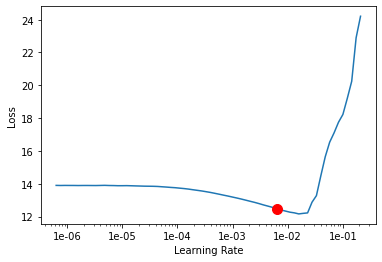

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, 1e-03)

epoch,train_loss,valid_loss,time
0,3.774407,5.221917,01:57
1,3.707633,4.425027,01:48
2,3.451187,4.769958,01:48
3,3.366151,4.540408,01:52


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 15)
learn = Learner(data, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))])

Free up some RAM

In [ ]:
# del id_vecs
# del en_vecs

As loss is not very interpretable, let's also look at the accuracy. We will add padding so that the output and target are of the same length

In [ ]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

### Bleu metric

In translation, the metric usually used is BLEU

In [ ]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [ ]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [ ]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [ ]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training with metrics

In [ ]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 15)
learn = Learner(data, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))])

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-03
Min loss divided by 10: 1.91E-03


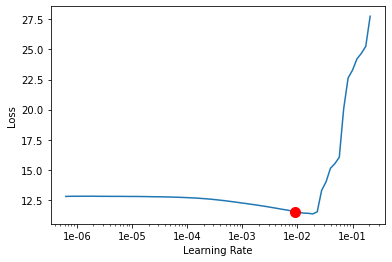

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, 1e-03)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.086548,4.593833,0.384255,0.246036,02:31
1,3.541393,4.865546,0.362524,0.238358,02:24
2,3.197293,4.534977,0.395584,0.271520,02:25
3,3.332001,4.466666,0.404042,0.278745,02:23


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,3.772251,4.590856,0.373919,0.240374,02:24
1,3.866218,4.757324,0.351872,0.211409,02:29
2,3.708993,4.847434,0.343120,0.194944,02:29
3,3.558897,4.865638,0.345390,0.212821,02:28


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


How good is our model? Let's see a few predictions

In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [ ]:
inputs, targets, outputs = get_predictions(learn)

TypeError: ignored

In [ ]:
inputs[700], targets[700], outputs[700]

In [ ]:
inputs[701], targets[701], outputs[701]

In [ ]:
inputs[2513], targets[2513], outputs[2513]

(Text [  2  18  21  33 341 145   0  54   0 116 662   9],
 Text [   2   18   71   11  348   16 1011   38    0   66    0   16  176   38   16  605    9],
 Text [ 2 18 15 11 66 66 66 66 66 66  9])

In [ ]:
inputs[4000], targets[4000], outputs[4000]

(Text [  2  13  45  99 121  82  11  29  23   9],
 Text [  2  12  15  11  62 643   9],
 Text [ 2 12 23 16 22 50 50  9  9])

## Teacher forcing

In [ ]:
class TeacherForcing(LearnerCallback):
    
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

In [ ]:
class Seq2SeqRNN_tf(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
            
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [ ]:
rnn_tf = Seq2SeqRNN_tf(emb_enc, emb_dec, 256, 30)

learn = Learner(data, rnn_tf, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
               callback_fns=partial(TeacherForcing, end_epoch=3))

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-04
Min loss divided by 10: 5.75E-03


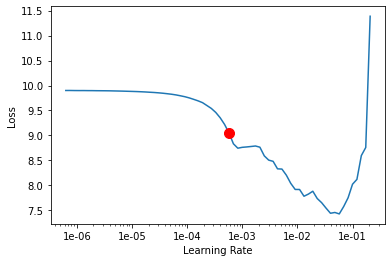

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,1.600849,3.756059,0.545896,0.426586,02:51
1,1.790631,4.037544,0.468737,0.380531,02:44
2,2.369862,3.970083,0.460270,0.366083,02:36
3,2.996956,4.148040,0.437626,0.314667,02:27


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
learn.fit_one_cycle(6, 5.75E-04)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,1.225084,3.629152,0.546975,0.452166,02:47
1,1.554503,3.694805,0.504945,0.410816,02:41
2,2.113296,3.572262,0.501074,0.403314,02:37
3,2.871263,3.991681,0.454345,0.332910,02:29
4,2.548857,3.868540,0.468407,0.346784,02:30
5,2.784968,3.853039,0.470487,0.349309,02:29


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
inputs, targets, outputs = get_predictions(learn)

In [ ]:
inputs[700],targets[700],outputs[700]

In [ ]:
inputs[2513], targets[2513], outputs[2513]

In [ ]:
inputs[4000], targets[4000], outputs[4000]